### Úkol

Zadání tohoto úkolu prověřuje vaše pochopení látky probírané na cvičení. Jeho cílem je implementace __výpočtu nejkratší vzdálenosti mezi obdélníky__ na snímku, který jste si **pořídili na cvičení**. 
:warning: Pokud jste nebyli na cvičení, kde se snímky potřebné k úkolu pořizovaly, napište email některému z cvičících.

Úkol má první __základní část s nápovědami__ a druhou __dobrovolnou část__ s bonusovými rozšířeními. Maximální počet bodů za __základní část je 5__, z bonusové části je možné získat až __2 prémiové__. Podrobnosti o bonusech jsou na konci notebooku. Pokud si s něčím nebudete dlouho vědět rady, napište email a domluvíme konzultaci.


Nyní uvažujme pouze základní variantu. Na začátek si je důležité uvědomit, že se __nejedná o vzdálenost mezi středy obdélníků__, nýbrž o nejkratší možné vzdálenosti hran objektů viz. [obrázek](images/patterns_lengths_example.JPG). Nezoufejte nyní, pokud nevíte jak vzdálenosti vypočítat, nápovědy v notebooku vám pomohou s řešením. Nemusíte se však striktně držet postupu, jakákoliv __individualita je vítaná__. K funkčnímu řešení se dá dobrat různými způsoby.

![](images/patterns_lengths_example.jpg)


Možná se ptáte, k čemu je to vlastně dobré. Motivace je ale jednoduchá - jedná se totiž o celkem běžně řešený problém v praxi. Navíc, v knihovně OpenCV pro to __neexistuje nativní implementace__, takže pokud zůstanete v oboru, může se vám to v budoucnu hodit. Představte si nyní, že vytváříte aplikaci, která má za úkol automatizovaně hrát hru ve které je nutné předcházet kolizím objektů ve scéně. Objekty umíte lokalizovat a ohraničit (nejčastěji obdélníkem), a mohou být různě velké a natočené. Jak nyní zjistit, jak jsou od sebe objekty daleko? V případě, že nebudou objekty (tedy ani obdélníky) natočené, lze vzdálenost vypočíst se znalostí středoškolské geometrie. V reálných situacích se tohle ale moc často nestává. Objekty jsou většinou libovolně natočené a tím se řešení trochu komplikuje. Stále si ale vystačíme se znalostí analytické geometrie ze střední školy, jen bude potřeba trochu programování navíc. Mimo kolize ve hře si můžeme představit využití i např. v aplikaci pro sledování pohybujících se objektů nebo monitorování průmyslových procesů (výrobní linka, spojování materiálů, atd.). 

Abychom si zbytečně nekomplikovali život, budeme řešení implementovat pouze na jednoduchém statickém snímku s několika obdélníky. __Zdrojový snímek základní verze__ je ten, kde jsou pouze obdélníky. Využijeme naší znalost ze cvičení a budou nás __zajímat nejkratší vzdálenosti v centimetrech__, nikoliv v pixelech.
![](images/patterns_thumb.jpg)

Předpokladem tohoto úkolu je, že __máte vypracovaný notebook ze cvičení Základy segmentace__. Budeme totiž znovu potřebovat segmentované kontury všech objektů, a vzhledem k tomu, že už máme nějakou práci hotovou, byla by škoda na ni nenavázat. Využijeme tedy vypracovaný notebook ze cvičení, upravíme pouze barevné intervaly ve funkcích `inRange()` (nově `segmentation_two_thresholds()` z __improutils__) tak, aby dávaly smysl pro nový zdrojový obrázek. 

### Import knihoven a konfigurace

In [246]:
import cv2
import numpy as np
import math

from improutils import *

### Základy segmentace (v kostce)
Postup je upravená a zrychlená verze cvičení __Základy segmentace__ s využitím funkcí z knihovny `improutils`.

In [247]:
# načtení obrazu
img = load_image('images/basic.jpg')

Nalezneme treshholdy pro segmentaci referenčního obdélníku:

In [250]:
from ipywidgets import interact, IntSlider

def adjust_thresholds_rect_ref(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b):
    lower_thresh = (lower_b, lower_g, lower_r)
    upper_thresh = (upper_b, upper_g, upper_r)
    mask = segmentation_two_thresholds(img, lower_thresh, upper_thresh)
    plot_images(mask)

interact(adjust_thresholds_rect_ref,
         lower_r=IntSlider(min=0, max=255, value=0, description='Lower R'),
         lower_g=IntSlider(min=0, max=255, value=0, description='Lower G'),
         lower_b=IntSlider(min=0, max=255, value=0, description='Lower B'),
         upper_r=IntSlider(min=0, max=255, value=255, description='Upper R'),
         upper_g=IntSlider(min=0, max=255, value=255, description='Upper G'),
         upper_b=IntSlider(min=0, max=255, value=255, description='Upper B'))

interactive(children=(IntSlider(value=0, description='Lower R', max=255), IntSlider(value=0, description='Lowe…

<function __main__.adjust_thresholds_rect_ref(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b)>

Nalezneme treshholdy pro segmentaci ostatních obdélníku:

In [251]:
from ipywidgets import interact, IntSlider

def adjust_thresholds_rect_ref(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b):
    lower_thresh = (lower_b, lower_g, lower_r)
    upper_thresh = (upper_b, upper_g, upper_r)
    mask = segmentation_two_thresholds(img, lower_thresh, upper_thresh)
    plot_images(mask)

interact(adjust_thresholds_rect_ref,
         lower_r=IntSlider(min=0, max=255, value=0, description='Lower R'),
         lower_g=IntSlider(min=0, max=255, value=0, description='Lower G'),
         lower_b=IntSlider(min=0, max=255, value=0, description='Lower B'),
         upper_r=IntSlider(min=0, max=255, value=255, description='Upper R'),
         upper_g=IntSlider(min=0, max=255, value=255, description='Upper G'),
         upper_b=IntSlider(min=0, max=255, value=255, description='Upper B'))

interactive(children=(IntSlider(value=0, description='Lower R', max=255), IntSlider(value=0, description='Lowe…

<function __main__.adjust_thresholds_rect_ref(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b)>

In [252]:
lower_bounds_ref = (103, 66, 0)
upper_bounds_ref = (255, 255, 52)

lower_bounds_others = (0, 123, 74)
upper_bounds_others = (93, 163, 255)

# segmentace obdélníků
rect_others = segmentation_two_thresholds(img, lower_bounds_others, upper_bounds_others) ### prahy pro segmentaci v RGB
rect_ref = segmentation_two_thresholds(img, lower_bounds_ref, upper_bounds_ref) ### prahy pro segmentaci v RGB
rect_mask = cv2.add(rect_others, rect_ref)

# nalezení referenčního obdélníku podle velikosti kontury
drawn_ref, _, ref_cnt = find_contours(rect_mask, 100000, 220000)

# nalezení kontur všech obdélníků
drawn_all, _, all_cnt = find_contours(rect_mask, 25000, 400000)

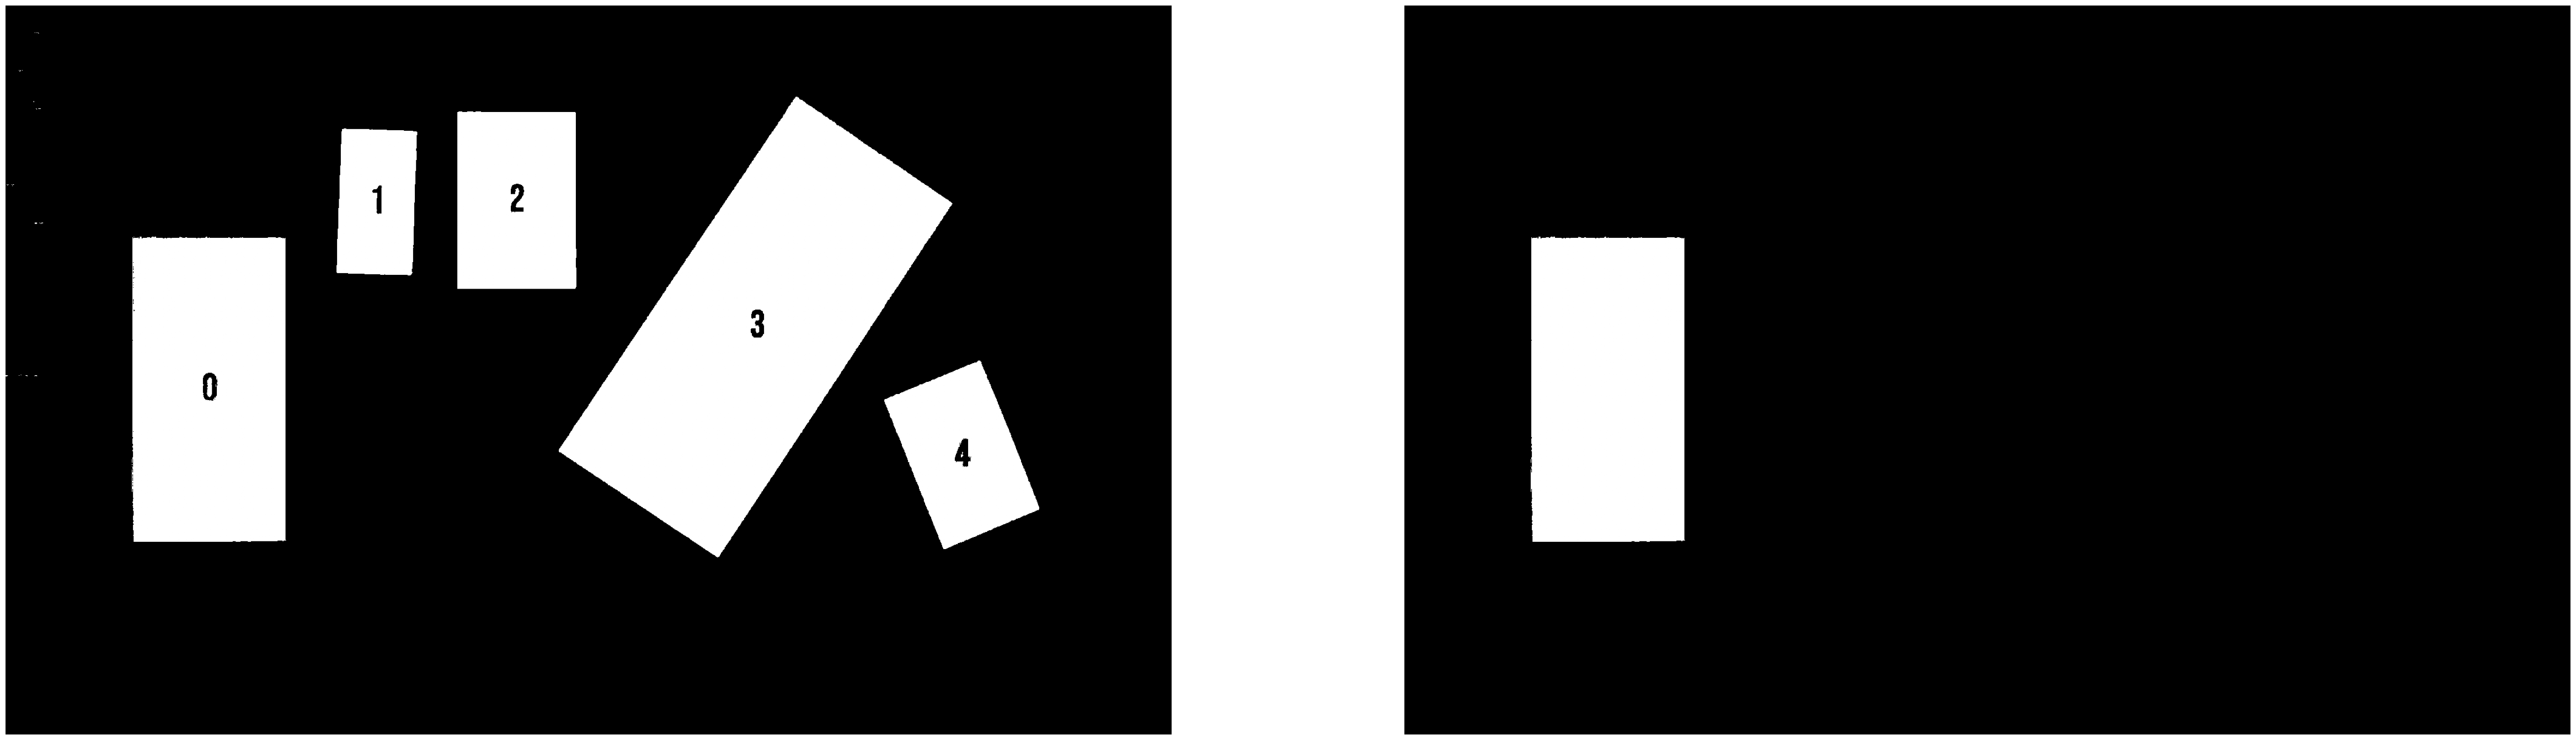

In [253]:
# zobrazení pro kontrolu
plot_images(rect_mask, drawn_ref)

In [254]:
# vypočtení poměru mm/pix
ref_width_real = 40
ref_height_real = 80

rect = cv2.minAreaRect(ref_cnt[0])
ref_width_image, ref_height_image = rect[1]
real_image_ratio = min(ref_width_real, ref_height_real) / min(ref_width_image, ref_height_image)
print(f'Ratio between real width and image width: {real_image_ratio}')

Ratio between real width and image width: 0.15810276679841898


### Základní část

In [255]:
import itertools
import math
import cv2

V řešení ze cvičení už máme hotové segmentace referenčního i ostatních objektů uložené formou kontur. 
Všechny tyto kontury se vyplatí přemístit do jedné struktury, neboť se s ní následně bude lépe pracovat, a seřadit dle čísel, tzn. zleva do prava dle středu obdélníku.

__1) Přesuňte všechny kontury do jedné struktury (např. list).__

In [256]:
# Vytvoření seznamu trojic (kontura, střed_x, střed_y)
contours_with_centers = []
for cnt in all_cnt:
    rect = cv2.minAreaRect(cnt)
    center = rect[0]  # (cx, cy)
    contours_with_centers.append((cnt, center[0], center[1]))

__2) seřaďte kontury tak, aby řazení odpovídalo ID jednotlivých obdélníků, tzn. zleva doprava dle středu kontury (obdélníků), v případě rovnosti pozice středu zhora dolů__

In [257]:
contours_with_centers.sort(key=lambda x: (x[1], x[2]))

sorted_contours = [cnt for cnt, cx, cy in contours_with_centers]

__3) Pomocí funkce `len()` ověřte, že jich máte správný počet.__

In [258]:
lenght = len(sorted_contours)
print(lenght)

5


__4) Uložte si hodnoty všech možných indexů předchozího listu do nového listu. Může se vám k tomu hodit funkce `range()` + `list()`. Ideálně využijte i předchozí informaci o počtu kontur.__

In [259]:
contour_indices = list(range(lenght))
print(f'Indexy kontur: {contour_indices}')

Indexy kontur: [0, 1, 2, 3, 4]


__5) Využijte funkci `itertools.combinations()` k získání všech možných dvojic kombinací indexů kontur. Pro jistotu si je vypiště.__

In [260]:
indices_pairs = list(itertools.combinations(contour_indices, 2))
print(indices_pairs)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


Nyní už to konečně začne být trochu zajímavé. Zbývá __projít všechny možné kombinace kontur, aproximovat je obdélníkem
vypočítat vzdálenost mezi všemi obdélníky, a výsledek vhodně vizualizovat v reálných jednotkách__. 
To je na jednu Jupyter buňku až moc operací, lepší řešení tedy bude tyto kroky rozpadnout do několika funkcí.

Způsobů výpočtu nejkratší vzdáleností mezi obdelníky je více. Můžete samozřejmě využít jakékoliv řešení budete chtít (za předpokladu korektnosti výsledků). V tomto postupu budem však uvažovat pouze jedno a to, které se nám zdálo nejjednoduší na pochopení. 

Pro zjedodnušení celé úlohy __není nutné uvažovat žádné složité speciální případy__ - nejsme Progtest. Nemusíte tedy uvažovat, že se tvary jakkoliv překrývají. Předpokládáme, že vzdálenost je vždy > 0. S tím také souvisí pozdější detaily jako __neřešení případů bodu ležícího na úsečce, úsečky se protínají, atd__.

Začneme tedy prvním stavebním kamenem našeho algoritmu, tedy __funkcí, která vypočte vzdálenost bodu od úsečky v pixelech__. Tato funkce je jádrem celého našeho řešení, je tedy nutné si ověřit, že vrací správné hodnoty.

Pokud vůbec netušíte, jak byste takovou věc implementovali, hledejte klíčová slova `"distance between line segment and point"` a inspirujte se. Nezapomeňte však __uvést zdroj__ + případne okomentování. __Dejte si pozor, že line segment != line__, pracujeme pouze s úsečkami.

__6) Doplňte funkci pro výpočet vzdálenosti mezi úsečkou a bodem.__

In [261]:
def line_segment_to_point_dist(l_pt1, l_pt2, dst_pt):
    x1, y1 = l_pt1
    x2, y2 = l_pt2
    x3, y3 = dst_pt

    # Výpočet délky úseček
    dx = x2 - x1
    dy = y2 - y1

    # Případ, kdy je úsečka ve skutečnosti bod
    if dx == 0 and dy == 0:
        return math.hypot(x3 - x1, y3 - y1)

    # Projekční bod
    t = ((x3 - x1) * dx + (y3 - y1) * dy) / (dx * dx + dy * dy)

    # Projekční bod leží před začátkem úsečky
    if t < 0:
        closest_x, closest_y = x1, y1

    # Projekční bod leží za koncem úsečky
    elif t > 1:
        closest_x, closest_y = x2, y2

    # Projekční bod leží na úsečce
    else:
        closest_x = x1 + t * dx
        closest_y = y1 + t * dy

    closest_point = (closest_x, closest_y)

    # Vypočteme vzdálenost mezi bodem dst a nejbližším bodem na úsečce
    distance = math.hypot(x3 - closest_x, y3 - closest_y)

    # Vracíme zároveň closest_point, pro využití u bonusové úlohu vizualizace
    return distance, closest_point

__7) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [262]:
assert line_segment_to_point_dist((1,3), (3,4), (4,4))[0] ==  1
assert line_segment_to_point_dist((0, 0), (10, 0), (5, 5))[0] == 5
assert line_segment_to_point_dist((0, 0), (10, 0), (0, 5))[0] == 5
assert line_segment_to_point_dist((0, 0), (10, 0), (15, 5))[0] == math.hypot(15 - 10, 5 - 0)

Nyní potřebujeme další stavební blok, a to nejkratší vzdálenost dvou úseček. K tomu využijeme už hotovou funkci `line_segment_to_point_dist()`. Pokud vás nenapadá jak, zkuste si to nakreslit na papír.
Nezapomeňte, že __nemusíme uvažovat speciální případy__ (např. to, že se protínají). S využítím funkce `min()` je to dokonce pouze na jeden řádek kódu.

__8) Doplňte funkci pro výpočet vzdálenosti mezi dvěmi úsečkami.__

In [267]:
def line_segments_dist(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    # Vypočítáme vzdálenost a body mezi kterými je nejmenší, což se nám bude opět hodit pro bonusovou úlohu
    distances = []
    point_pairs = []

    # Vzdálenost od l2_pt1 k úsečce l1
    dist, closest_pt = line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt1)
    distances.append(dist)
    point_pairs.append((closest_pt, l2_pt1))

    # Vzdálenost od l2_pt2 k úsečce l1
    dist, closest_pt = line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt2)
    distances.append(dist)
    point_pairs.append((closest_pt, l2_pt2))

    # Vzdálenost od l1_pt1 k úsečce l2
    dist, closest_pt = line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt1)
    distances.append(dist)
    point_pairs.append((l1_pt1, closest_pt))

    # Vzdálenost od l1_pt2 k úsečce l2
    dist, closest_pt = line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt2)
    distances.append(dist)
    point_pairs.append((l1_pt2, closest_pt))

    # Najdeme minimální vzdálenost a odpovídající dvojici bodů
    min_index = distances.index(min(distances))
    min_distance = distances[min_index]
    closest_points = point_pairs[min_index]

    return min_distance, closest_points


__9) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [268]:
assert line_segments_dist((1,3), (3,4), (5,7), (5,1))[0] ==  2
assert line_segments_dist((1,5),(6,5), (7,7), (7,5))[0] == 1
assert line_segments_dist((0, 0), (10, 0), (0, 5), (10, 5))[0] == 5
assert line_segments_dist((0, 0), (0, 10), (3, 0), (3, 10))[0] == 3
assert line_segments_dist((0, 0), (0, 2), (2, 2), (4, 2))[0] == 2

Když už umíme vypočítat nejkratší vzdálenost dvou úseček, máme vše potřebné pro výpočet nejkratší vzdálenosti mezi dvěma obdélníky. Stačí si jen uvědomit, že obdélník je složen ze čtyř spojených úseček. 

Typ vstupních parametrů funkce `rect_dist` je na vás. Nezapomeňte však, že `cv2.minAreaRect()` nevrací přímo souřadnice rohových bodů. Připomeňte si `cv2.boxPoints()` a `order_points()`.

__10) Doplňte funkci pro výpočet vzdálenosti mezi dvěma obdélníky.__

In [269]:
def rect_dist(r1_pts, r2_pts):

    distances = []
    point_pairs = []

    # Vzdálenost "úseček" obdélníků
    for i in range(4):
        l1_pt1 = r1_pts[i]
        l1_pt2 = r1_pts[(i + 1) % 4]
        for j in range(4):
            l2_pt1 = r2_pts[j]
            l2_pt2 = r2_pts[(j + 1) % 4]
            dist, closest_points = line_segments_dist(l1_pt1, l1_pt2, l2_pt1, l2_pt2)
            distances.append(dist)
            point_pairs.append(closest_points)

    # Vrcholy r1 vůči hranám r2
    for pt in r1_pts:
        for j in range(4):
            l2_pt1 = r2_pts[j]
            l2_pt2 = r2_pts[(j + 1) % 4]
            dist, closest_points = line_segment_to_point_dist(l2_pt1, l2_pt2, pt)
            distances.append(dist)
            point_pairs.append(closest_points)

    # Vrcholy r2 vůči hranám r1
    for pt in r2_pts:
        for j in range(4):
            l1_pt1 = r1_pts[j]
            l1_pt2 = r1_pts[(j + 1) % 4]
            dist, closest_points = line_segment_to_point_dist(l1_pt1, l1_pt2, pt)
            distances.append(dist)
            point_pairs.append(closest_points)


    # Najdeme minimální vzdálenost a odpovídající dvojici bodů
    min_index = distances.index(min(distances))
    min_distance = distances[min_index]
    closest_points = point_pairs[min_index]
    
    return min_distance, closest_points

__11) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [270]:
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((7,7), (9,7), (9, 5), (7, 5)))[0] == 1
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((4,10), (6, 8), (4, 6), (2,8)))[0] == 1

assert rect_dist(((0,0), (4,0), (4,3), (0,3)), ((9,0), (13,0), (13,3), (9,3)))[0] == 5
assert rect_dist(((0,0), (3,0), (3,4), (0,4)), ((0,6), (3,6), (3,10), (0,10)))[0] == 2
assert rect_dist(((0,0), (2,0), (2,4), (0,4)), ((5,0), (7,0), (7,4), (5,4)))[0] == 3
assert rect_dist(((0,0), (4,0), (4,2), (0,2)), ((0,2.5), (4,2.5), (4,4.5), (0,4.5)))[0] == 0.5

Blížíme se do finále. Úplně v první buňce tohoto úkolu bychom měli mít vytvořený list se všemi konturami a list všech dvojic kombinací indexů kontur. Kontury vhodně převeďte tak, aby je bylo možné předat do definované funkce `rect_dist()` a tím získat vzdálenost mezi dvěma obdélníky v pixelech. Následně přepočítejte pixely na skutečné jednotky a vypiště nalezené vzdálenosti ve vhodném a kontrolovatelném formátu (např.: 1 <-> 3: 2.2 cm). 

__12) Vypočítejte vzdálenosti mezi všemi obdélníky ve snímku, vypiště vzdálenosti ve vhodném formátu v centimetrech.__

In [271]:
for comb in indices_pairs:
    r1_pts = order_points(cv2.boxPoints(cv2.minAreaRect(sorted_contours[comb[0]])))
    r2_pts = order_points(cv2.boxPoints(cv2.minAreaRect(sorted_contours[comb[1]])))
    distance_in_px = rect_dist(r1_pts, r2_pts)[0]
    distance_in_cm = (distance_in_px * real_image_ratio)/10
    print(f'{comb[0]} <-> {comb[1]} => {round(distance_in_cm,1)} cm')

0 <-> 1 => 1.3 cm
0 <-> 2 => 4.5 cm
0 <-> 3 => 7.1 cm
0 <-> 4 => 15.5 cm
1 <-> 2 => 1.0 cm
1 <-> 3 => 5.7 cm
1 <-> 4 => 12.7 cm
2 <-> 3 => 1.9 cm
2 <-> 4 => 8.5 cm
3 <-> 4 => 1.3 cm


### Bonusová část

Pokud to pro vás byla doposuď zívačka, a chtěli byste nějaké body navíc, je možné získat až 2 prémiové body za trochu dalšího přemýšlení a programování. Za každý splněný úkol ze seznamu je __1 prémiový bod__. Maximálně je možné získat __až 2 prémiové__.

#### Úkoly:
1) Vytvořte vhodnou vizualizaci vzdáleností mezi objekty. Např. vykreslení nejkratší úsečky mezi obdélníky a vypsání její délky v centimetrech.

2) Upravte váš algoritmus tak, aby korektně fungoval i pro bonusový snímek, který obsahuje kromě obdélníků i kružnice. Tedy podpora výpočtu nejkratší vzdálenosti mezi kombinací tvarů obdélník a kružnice. Jiné elipsové tvary pro jednoduchost neuvažujte. Může se vám na to hodit `cv2.fitEllipse()`.

3) Zkuste navrhnout jiné řešení než to využívající vzdálenost bodů od úsečky. Nemusí být 100% funkční ve všech případech, ale jasně vyspecifikujte jeho úskalí a případy kdy nebude fungovat.

### 1. Vizualizace ###

Upravíme přechozí funkce tak, aby nám vraceli zároveň body, mezi kterými je vzdálenost obdélníků nejmenší pro vykreslení úseček. Aby kód nebyl víceméně duplicitní, implementaci jsem provedl přímo do původních funkcí. Vizte komentáře v těchto funkcích.

In [272]:
output_img = img.copy()

for comb in indices_pairs:
    r1_pts = order_points(cv2.boxPoints(cv2.minAreaRect(sorted_contours[comb[0]])))
    r2_pts = order_points(cv2.boxPoints(cv2.minAreaRect(sorted_contours[comb[1]])))
    distance_in_px, closest_points = rect_dist(r1_pts, r2_pts)
    distance_in_cm = (distance_in_px * real_image_ratio)/10
    
    distance_to_print = f'{distance_in_cm:.1f}'
    print(f'{comb[0]} <-> {comb[1]} => {distance_to_print} cm')

    # Vykreslení nejkratší úsečky
    pt1 = tuple(map(int, closest_points[0]))
    pt2 = tuple(map(int, closest_points[1]))
    cv2.line(output_img, pt1, pt2, (0, 255, 0), 2)

    # Zobrazení délky v cm
    mid_point = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)
    label_text = f'{distance_to_print} cm'
    cv2.putText(output_img, label_text, mid_point,
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

0 <-> 1 => 1.3 cm
0 <-> 2 => 4.5 cm
0 <-> 3 => 7.1 cm
0 <-> 4 => 15.5 cm
1 <-> 2 => 1.0 cm
1 <-> 3 => 5.7 cm
1 <-> 4 => 12.7 cm
2 <-> 3 => 1.9 cm
2 <-> 4 => 8.5 cm
3 <-> 4 => 1.3 cm


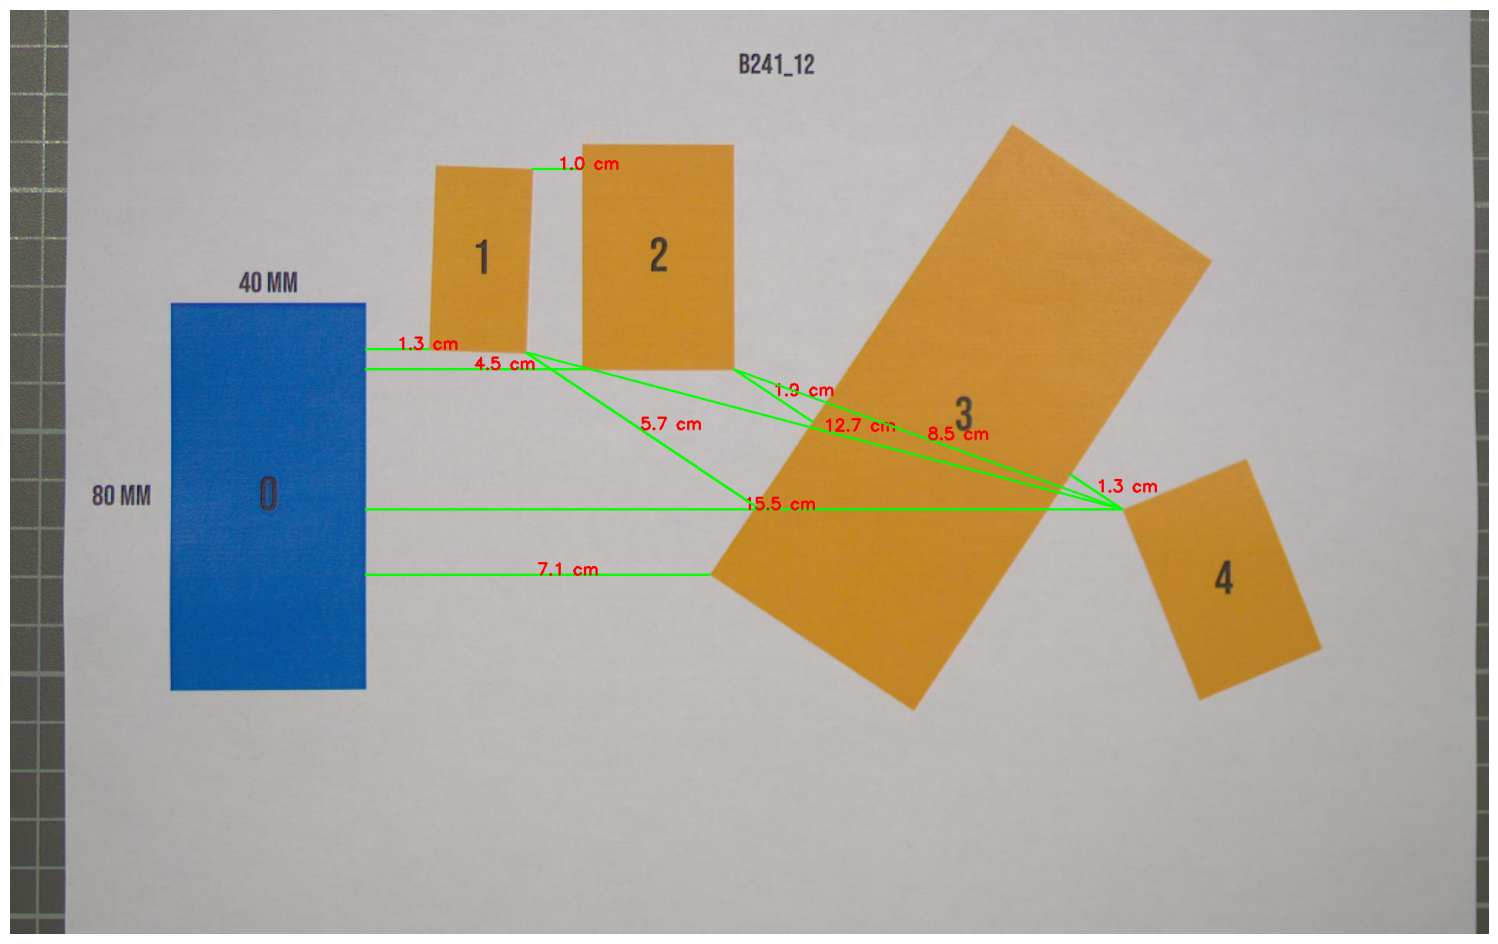

In [273]:
plot_images(output_img)

### 2. Úprava pro bonusový obrázek ###

In [274]:
# načtení obrazu
img_bonus = load_image('images/bonus.jpg')

In [275]:
from ipywidgets import interact, IntSlider

def adjust_thresholds_rect_ref(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b):
    lower_thresh = (lower_b, lower_g, lower_r)
    upper_thresh = (upper_b, upper_g, upper_r)
    mask = segmentation_two_thresholds(img_bonus, lower_thresh, upper_thresh)
    plot_images(mask)

interact(adjust_thresholds_rect_ref,
         lower_r=IntSlider(min=0, max=255, value=0, description='Lower R'),
         lower_g=IntSlider(min=0, max=255, value=0, description='Lower G'),
         lower_b=IntSlider(min=0, max=255, value=0, description='Lower B'),
         upper_r=IntSlider(min=0, max=255, value=255, description='Upper R'),
         upper_g=IntSlider(min=0, max=255, value=255, description='Upper G'),
         upper_b=IntSlider(min=0, max=255, value=255, description='Upper B'))



interactive(children=(IntSlider(value=0, description='Lower R', max=255), IntSlider(value=0, description='Lowe…

<function __main__.adjust_thresholds_rect_ref(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b)>

In [277]:
from ipywidgets import interact, IntSlider

def adjust_thresholds_others(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b):
    lower_thresh = (lower_b, lower_g, lower_r)
    upper_thresh = (upper_b, upper_g, upper_r)
    mask = segmentation_two_thresholds(img_bonus, lower_thresh, upper_thresh)
    plot_images(mask)

interact(adjust_thresholds_others,
         lower_r=IntSlider(min=0, max=255, value=0, description='Lower R'),
         lower_g=IntSlider(min=0, max=255, value=0, description='Lower G'),
         lower_b=IntSlider(min=0, max=255, value=0, description='Lower B'),
         upper_r=IntSlider(min=0, max=255, value=255, description='Upper R'),
         upper_g=IntSlider(min=0, max=255, value=255, description='Upper G'),
         upper_b=IntSlider(min=0, max=255, value=255, description='Upper B'))



interactive(children=(IntSlider(value=0, description='Lower R', max=255), IntSlider(value=0, description='Lowe…

<function __main__.adjust_thresholds_others(lower_r, lower_g, lower_b, upper_r, upper_g, upper_b)>

In [278]:
lower_bounds_ref = (158, 0, 0)
upper_bounds_ref = (255, 98, 255)

lower_bounds_others = (0, 82, 124)
upper_bounds_others = (174, 150, 255)

# segmentace
rect_others = segmentation_two_thresholds(img_bonus, lower_bounds_others, upper_bounds_others) ### prahy pro segmentaci v RGB
rect_ref = segmentation_two_thresholds(img_bonus, lower_bounds_ref, upper_bounds_ref) ### prahy pro segmentaci v RGB
rect_mask = cv2.add(rect_others, rect_ref)

# nalezení referenčního obdélníku podle velikosti kontury
drawn_ref, _, ref_cnt = find_contours(rect_mask, 115000, 220000)
#print(ref_cnt)

# nalezení kontur všech ostatních objektů
drawn_all, _, all_cnt = find_contours(rect_mask, 10000, 400000)

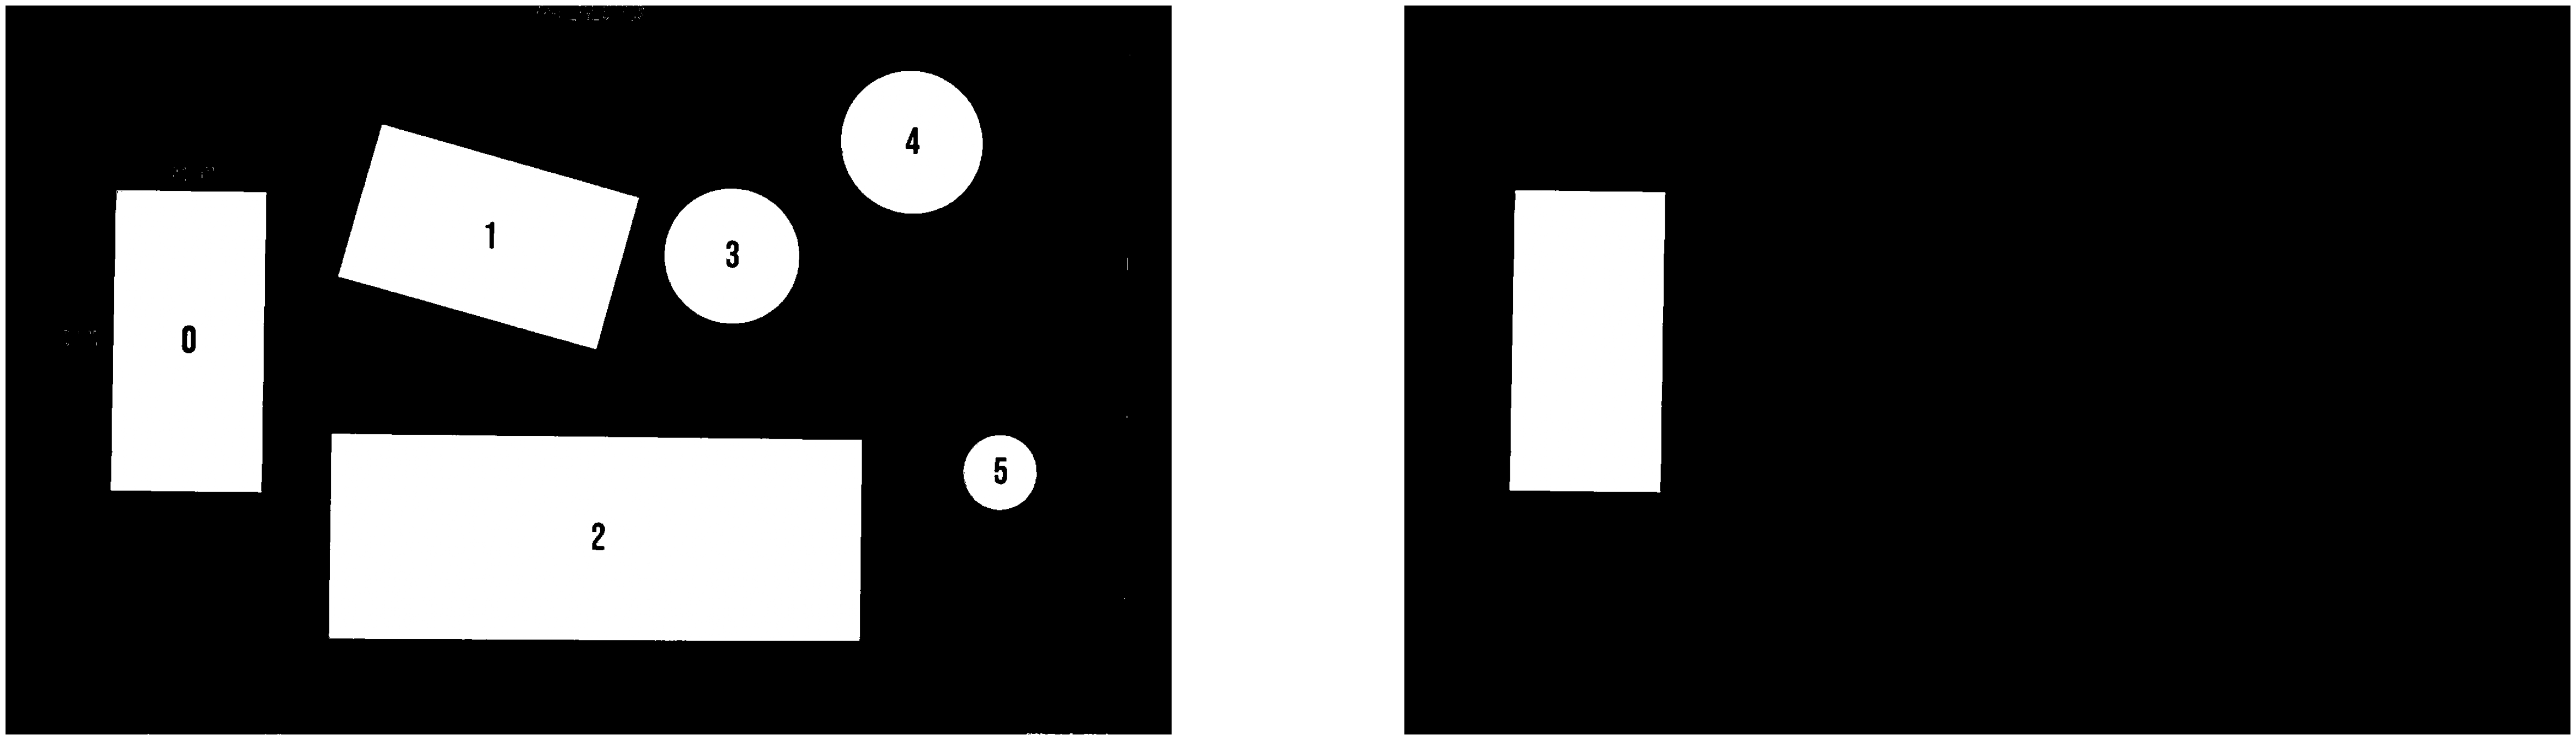

In [279]:
plot_images(rect_mask, drawn_ref)

In [281]:
# Klasifikace tvarů
shapes = []

for cnt in all_cnt:
    # Vypočítáme plochu aktuální kontury
    area = cv2.contourArea(cnt)

    # Vyfiltrujeme malé kontury
    if area > 1000:
        # Vypočítáme obvod kontury
        peri = cv2.arcLength(cnt, True)

        # Aproximujeme konturu na polygon s tolerancí 1%
        approx = cv2.approxPolyDP(cnt, 0.01 * peri, True)

        # Pokud má aproximovaný polygon 4 vrcholy
        if len(approx) == 4:
            # Obdélník
            shapes.append(('rectangle', cnt))
        else:
            # Ověříme, zda se jedná o kružnici
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            circle_area = np.pi * (radius ** 2)
            area_ratio = area / circle_area

            # Dokonalá kružnice by měla area_ratio 1
            if 0.7 < area_ratio < 1.3:
                shapes.append(('circle', (center, radius)))

Vytvoříme funkci pro výpočet vzdálenosti mezi obdélníkem a kružnicí

In [286]:
def rect_circle_dist(rect_pts, circle):
    circle_center = np.array(circle[0], dtype=np.float64)
    circle_radius = circle[1]

    min_distance = float('inf')
    closest_points = None

    # Pro každou hranu obdélníku
    for i in range(4):
        l_pt1 = rect_pts[i]
        l_pt2 = rect_pts[(i + 1) % 4]

        # Nejbližší bod na hraně obdélníku ke středu kružnice
        dist, proj_point = line_segment_to_point_dist(l_pt1, l_pt2, circle_center)

        # Upravená vzdálenost s odečtením poloměru kružnice
        adjusted_dist = dist - circle_radius

        # Aktualizace minimální vzdálenosti a nejbližších bodů
        if adjusted_dist < min_distance:
            min_distance = adjusted_dist
            # Vypočteme směr od středu kružnice k projekčnímu bodu
            direction = proj_point - circle_center
            norm = np.linalg.norm(direction)
            if norm != 0:
                direction /= norm
            # Nejbližší bod na kružnici
            closest_pt_circle = circle_center + direction * circle_radius
            closest_points = (tuple(proj_point), tuple(closest_pt_circle))

    # Pro každý vrchol obdélníku
    for pt in rect_pts:
        pt = np.array(pt, dtype=np.float64)
        # Vzdálenost od vrcholu ke středu kružnice
        dist = np.linalg.norm(pt - circle_center) - circle_radius

        # Aktualizace minimální vzdálenosti a nejbližších bodů
        if dist < min_distance:
            min_distance = dist
            # Nejbližší bod na kružnici z vrcholu
            direction = pt - circle_center
            norm = np.linalg.norm(direction)
            if norm != 0:
                direction /= norm
            closest_pt_circle = circle_center + direction * circle_radius
            closest_points = (tuple(pt), tuple(closest_pt_circle))

    return min_distance, closest_points

Vytvoříme funkci pro výpočet vzdálenosti mezi dvěma kružnicemi

In [287]:
def circle_circle_dist(circle1, circle2):
    center1 = np.array(circle1[0], dtype=np.float64)
    radius1 = circle1[1]
    center2 = np.array(circle2[0], dtype=np.float64)
    radius2 = circle2[1]

    dist_centers = np.linalg.norm(center1 - center2)
    dist = dist_centers - (radius1 + radius2)

    direction = (center2 - center1) / dist_centers
    point_on_circle1 = center1 + direction * radius1
    point_on_circle2 = center2 - direction * radius2

    closest_points = (point_on_circle1, point_on_circle2)
    return dist, closest_points


Vytvoření seznamu tvarů s jejich středy

In [306]:
shapes_with_centers = []
for shape in shapes:
    if shape[0] == 'rectangle':
        rect = cv2.minAreaRect(shape[1])
        center = rect[0]
    elif shape[0] == 'circle':
        center = shape[1][0]
    shapes_with_centers.append((shape[0], shape[1], center[0]))


In [307]:
shapes_with_centers.sort(key=lambda x: x[2])
sorted_shapes = shapes_with_centers

In [308]:
len(sorted_shapes)

6

In [309]:
indices_pairs = list(itertools.combinations(range(len(sorted_shapes)), 2))
print(indices_pairs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


Provedeme výpočet vzdáleností

In [310]:
output_img = img_bonus.copy()

for comb in indices_pairs:
    type1, shape1, _ = sorted_shapes[comb[0]]
    type2, shape2, _ = sorted_shapes[comb[1]]

    if type1 == 'rectangle' and type2 == 'rectangle':
        r1_pts = order_points(cv2.boxPoints(cv2.minAreaRect(shape1)))
        r2_pts = order_points(cv2.boxPoints(cv2.minAreaRect(shape2)))
        distance_in_px, closest_points = rect_dist_special(r1_pts, r2_pts)
    elif (type1 == 'rectangle' and type2 == 'circle') or (type1 == 'circle' and type2 == 'rectangle'):
        if type1 == 'rectangle':
            rect_pts = order_points(cv2.boxPoints(cv2.minAreaRect(shape1)))
            circle = shape2
        else:
            rect_pts = order_points(cv2.boxPoints(cv2.minAreaRect(shape2)))
            circle = shape1
        distance_in_px, closest_points = rect_circle_dist(rect_pts, circle)
    elif type1 == 'circle' and type2 == 'circle':
        distance_in_px, closest_points = circle_circle_dist(shape1, shape2)


    distance_in_cm = (distance_in_px * real_image_ratio)/10
    formatted_distance = f'{distance_in_cm:.1f}'
    print(f'{comb[0]} <-> {comb[1]} => {formatted_distance} cm')

    # Vykreslení nejkratší úsečky
    pt1 = tuple(map(int, closest_points[0]))
    pt2 = tuple(map(int, closest_points[1]))
    cv2.line(output_img, pt1, pt2, (0, 255, 0), 2)

    # Zobrazení délky v cm
    mid_point = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)
    label_text = f'{formatted_distance} cm'
    cv2.putText(output_img, label_text, mid_point,
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)


0 <-> 1 => 1.9 cm
0 <-> 2 => 1.8 cm
0 <-> 3 => 10.4 cm
0 <-> 4 => 15.0 cm
0 <-> 5 => 18.2 cm
1 <-> 2 => 2.3 cm
1 <-> 3 => 1.0 cm
1 <-> 4 => 5.4 cm
1 <-> 5 => 10.0 cm
2 <-> 3 => 3.0 cm
2 <-> 4 => 6.0 cm
2 <-> 5 => 2.6 cm
3 <-> 4 => 1.9 cm
3 <-> 5 => 6.2 cm
4 <-> 5 => 6.1 cm


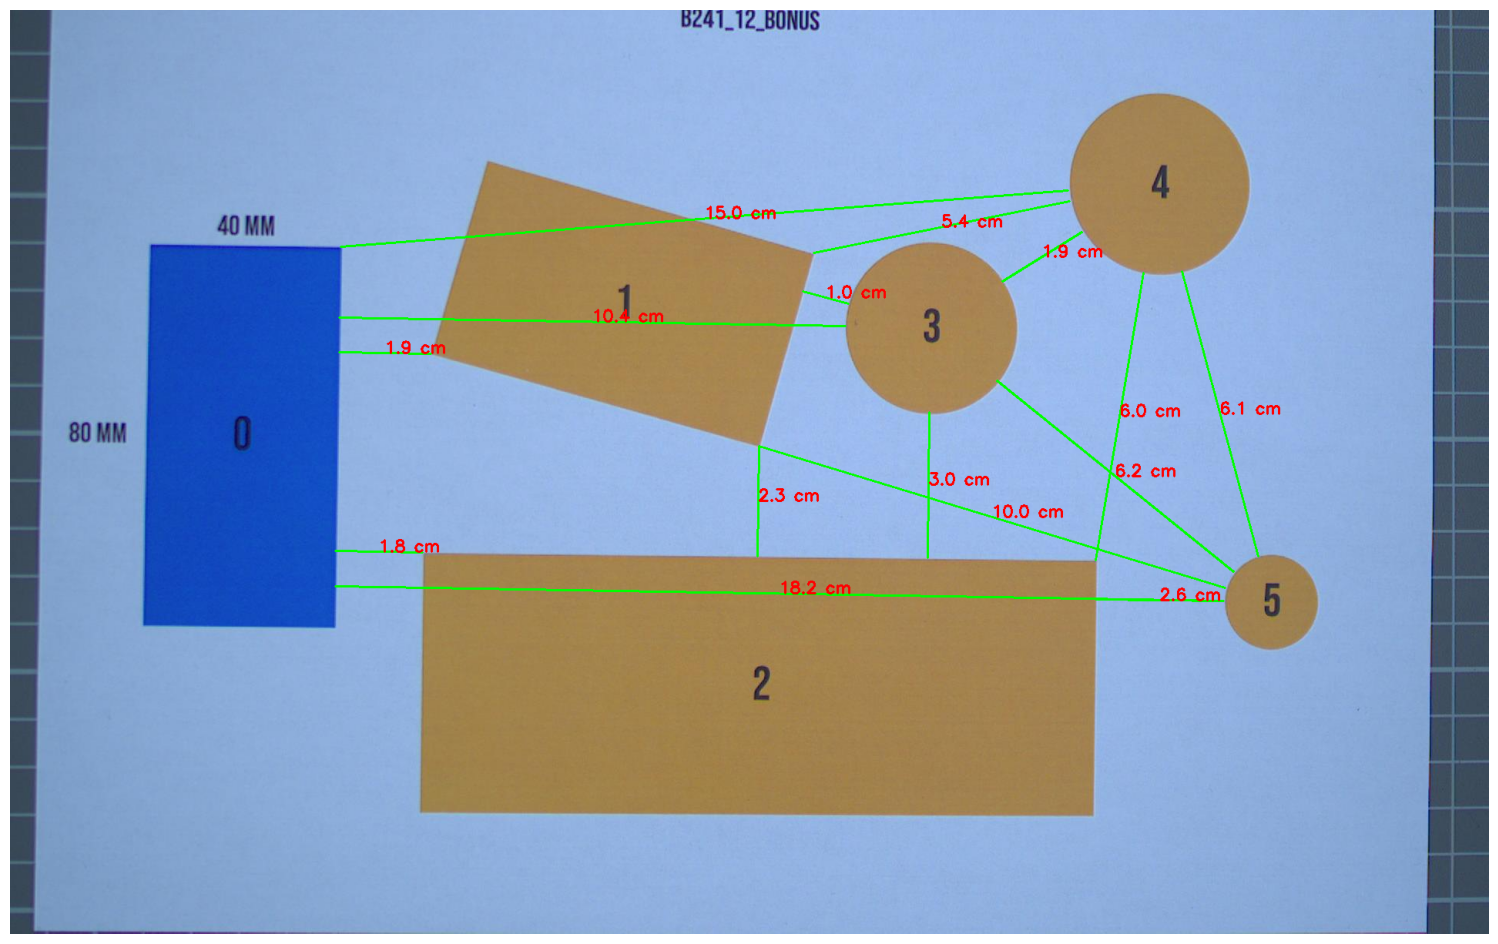

In [311]:
plot_images(output_img)